In [43]:
import numpy as np

import librosa
import librosa.display

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torch.nn.functional as F
import torchaudio
from torchaudio.models import WaveRNN

from torchvision.utils import make_grid 
import matplotlib.pyplot as plt    
import os
import random
from tqdm import tqdm 

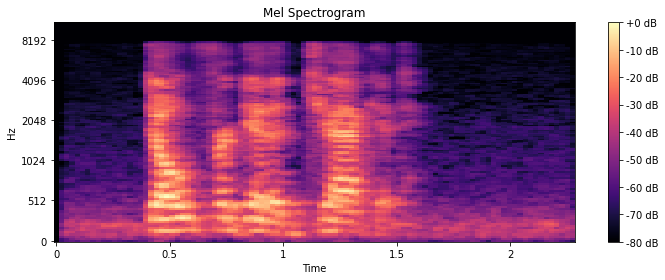

In [44]:
#Visualising the data

crema_d_spec_path = './AudioWAV/1001_DFA_ANG_XX.wav'
y, sr = librosa.load(crema_d_spec_path)

# Compute the spectrogram
spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

# Convert to decibel scale (log scale)
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

In [45]:
waveform, sample_rate = torchaudio.load(crema_d_spec_path)
print(waveform.size(), sample_rate)

torch.Size([1, 36409]) 16000


In [46]:

def get_label(type, filename):

    if(type == 'save'):
        if filename[-8:-6]=='_a':
            return 'ANG'
        elif filename[-8:-6]=='_d':
            return 'DIS'
        elif filename[-8:-6]=='_f':
            return 'FEA'
        elif filename[-8:-6]=='_h':
            return 'HAP'
        elif filename[-8:-6]=='_n':
            return 'NEU'
        elif filename[-8:-6]=='sa':
            return 'SAD'
        elif filename[-8:-6]=='su':
            return 'SU'
        else:
            return ''
    
    elif(type == 'crema_d'):
        return filename.split('_')[2]

    elif(type == 'ravdess'):
        part = filename.split('.')[0].split('-')
        emotion = int(part[2])
        if emotion == 1 or emotion == 2:
            return 'NEU'
        elif emotion == 3:
            return 'HAP'
        elif emotion == 4:
            return 'SAD'
        elif emotion == 5:
            return 'ANG'
        elif emotion == 6:
            return 'FEA'
        elif emotion == 7:
            return 'DIS'
        elif emotion == 8:
            return 'SU'

    elif(type == 'tess'):
        i = filename.split('_')[2]

        if i == 'angry':
            return 'ANG'
            
        elif i == 'disgust':
            return 'DIS'
            
        elif i == 'fear':
            return 'FEA'
            
        elif i == 'happy':
            return 'HAP'
            
        elif i == 'neutral':
            return 'NEU'
                                        
        elif i == 'ps':
            return 'SU'

        elif i == 'sad':
            return 'SAD'
            
    return ''

#for ravdess and tess
def load_other(directory, type):

    dir_list = os.listdir(diectory)
    dir_list.sort()
    emotion = []

    for i in dir_list:
        fname = os.listdir(directory + i)
        d = load_dataset(fname, type)
    return d

def load_dataset(directory, type):
    dataset = []
    emotion_to_number = {'NEU': 0, 'HAP': 1, 'SAD': 2, 'ANG': 3, 'DIS': 4, 'FEA': 5}
    
    # Iterate through files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.wav'):
            
            filepath = os.path.join(directory, filename)
            emotion = get_label(type,filename)
            emotion_no = emotion_to_number[emotion]
            emotion_label = torch.zeros(6)
            emotion_label[emotion_no] = 1
            
            # Load audio waveform
            waveform, sr = torchaudio.load(filepath)
            
            # Compute spectrogram
            mel_spec_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_mels=128, n_fft=1024, hop_length=256)
            spectrogram = mel_spec_transform(waveform)
            
            
            epsilon = 1e-10
            spec_db = 10 * torch.log10(spectrogram + epsilon)
            
            dataset.append((spec_db, emotion_label))

    return dataset


def split_dataset(dataset, batch_size, train_ratio=0.9):

    # Split dataset into training and testing sets
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader objects for training and testing sets
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_dataset, test_dataset, train_dataloader, test_dataloader

In [47]:
crema_d_path = './AudioWAV'

data_crema = load_dataset(crema_d_path, 'crema_d')

dataset = data_crema

print(len(dataset))


7442


In [48]:
def plot_emotion_distribution(dataset):
    # Count the number of instances for each emotion
    emotion_counts = {}
    for _, label in dataset:
        emotion = np.argmax(label.numpy())
        emotion_name = ['Neutral', 'Happy', 'Sad', 'Angry', 'Disgusted', 'Fearful'][emotion]
        emotion_counts[emotion_name] = emotion_counts.get(emotion_name, 0) + 1

    # Convert the dictionary to a sorted list of (emotion, count) tuples
    emotion_counts = sorted(emotion_counts.items(), key=lambda x: x[1], reverse=True)

    # Extract the emotion names and counts into separate lists
    emotions = [emotion for emotion, count in emotion_counts]
    counts = [count for emotion, count in emotion_counts]

    # Create a bar plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(emotions, counts)
    ax.set_xlabel('Emotion', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.set_title('Emotion Distribution in the Dataset', fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

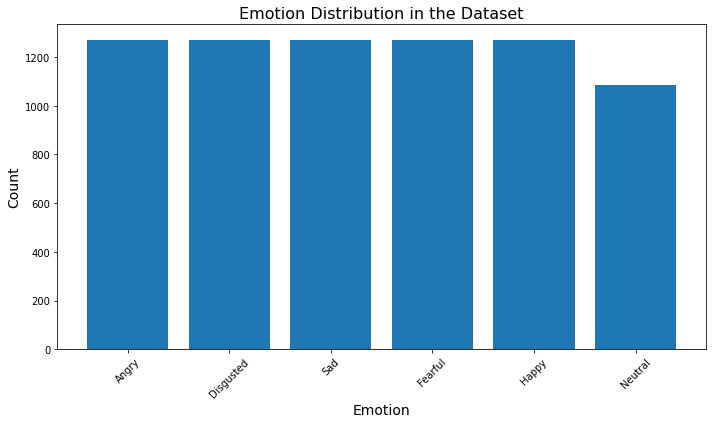

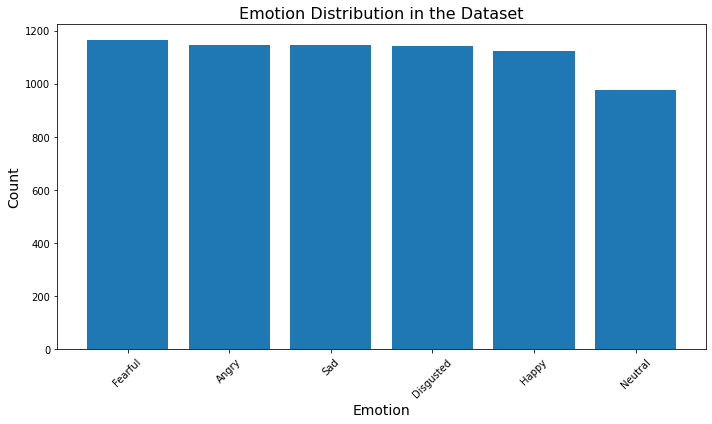

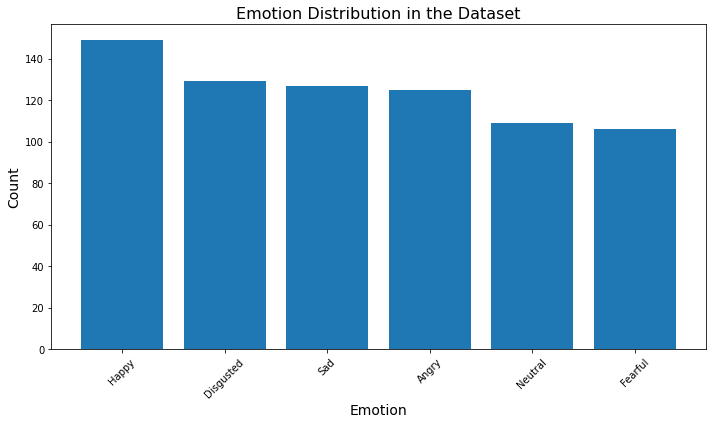

In [49]:
train_dataset, test_dataset, train_dataloader, test_dataloader = split_dataset(dataset, 1)

plot_emotion_distribution(dataset)
plot_emotion_distribution(train_dataset)
plot_emotion_distribution(test_dataset)

In [50]:
print(len(dataset))
for batch_idx, (s, l) in enumerate(train_dataloader):
    print(s.size())
    print(l.size())
    break


7442
torch.Size([1, 1, 128, 167])
torch.Size([1, 6])


In [51]:
 class RNN(nn.Module):
     def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.2):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)  # Add softmax layer
    
     def forward(self, x):
        # Flatten the spectrogram data along the frequency_bins dimension
        
        x = x.view(x.size(0), -1, x.size(3))  # [batch_size, channels * frequency_bins, time_steps]
        x = torch.permute(x,(0,2,1))
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out)
        out = self.softmax(out)
        return out
        
        # Only take the output from the last time step
      #   out = self.softmax(self.fc1(out[:, -1, :]))  # [batch_size, num_classes]
      #   out = self.softmax(self.fc2(out))  # Apply softmax activation
      #   return out

In [52]:
#training step - 1 epoch
def train_step(model, loss_function, optimizer, train_dataloader):

    losses = []
    for i, (specgram, label) in enumerate(tqdm(iter(train_dataloader))):
        optimizer.zero_grad()
        pred = model(specgram)
        # print(pred.size(), label.shape)
        label = label.long() 
        loss = loss_function(pred, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    return losses

In [53]:
batch_size = 1
lr = 1e-4

input_size = 128  # input size after flattening the spectrogram
hidden_size = 512  # size of the hidden state
num_layers = 6  # number of LSTM layers
num_classes = 6  # number of output classes

train_dataset, test_dataset, train_dataloader, test_dataloader = split_dataset(dataset, batch_size)

# Initialize the LSTM model
model = RNN(input_size, hidden_size, num_layers, num_classes)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses = train_step(model, loss_function, optimizer, train_dataloader)
print(losses)

[5.370624542236328, 4.709473133087158, 5.081313610076904, 5.236329555511475, 5.203871250152588, 5.225552082061768, 5.105693340301514, 5.003586292266846, 5.042998790740967, 4.955238342285156, 4.968999862670898, 5.26708459854126, 5.29225492477417, 4.953824520111084, 5.234255313873291, 5.255270957946777, 5.366575717926025, 4.97487735748291, 4.83860969543457, 5.156122207641602, 4.842934608459473, 4.851132392883301, 5.072304725646973, 4.937605381011963, 4.904870510101318, 5.145205974578857, 5.2891082763671875, 4.731441974639893, 4.922927379608154, 4.806824207305908, 5.169083118438721, 4.782342433929443, 4.7324137687683105, 5.1793904304504395, 4.361244201660156, 4.728147506713867, 4.778359889984131, 4.747229099273682, 4.635644435882568, 4.626978397369385, 4.892190456390381, 4.574039459228516, 4.690333843231201, 4.737518787384033, 4.769225597381592, 4.600643634796143, 4.593417644500732, 4.221070289611816, 4.289588451385498, 4.911059856414795, 4.571371555328369, 4.572967052459717, 4.4147109985

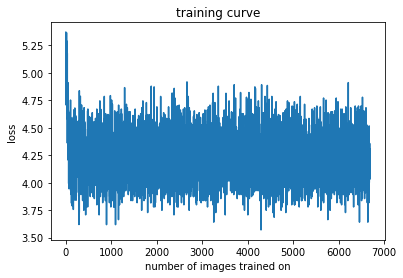

In [54]:
plt.plot(np.arange(len(losses)) * batch_size * 1, losses)
plt.title("training curve")
plt.xlabel("number of images trained on")
plt.ylabel("loss")
plt.show()

In [57]:
def test_accuracy(model, loss_function, test_data):

    '''
    This function will test the given model on the given test_data
    it will return the accuracy and the test loss (given by loss_function) 
    '''
    
    sum_loss = 0
    n_correct = 0
    total = 0

    for i, (spec, label) in enumerate(tqdm(iter(test_data))):

        # This is essentially exactly the same as the training loop 
        # without the, well, training, part (and we record the accuracy too)
        pred = model(spec)
        label = label.long()
        loss = loss_function(pred, label)
        sum_loss += loss.item()

        _, predicted = torch.max(pred,1)
        _, label = torch.max(label,1)
        n_correct += (predicted == label).sum()
        total += label.size(0)
    
    test_acc = round(((n_correct / total).item() * 100), 2)
    avg_loss = round(sum_loss / len(test_data), 2)

    print("test accuracy:", test_acc)
    print("test loss:", avg_loss )
    #test

    return test_acc, avg_loss

In [58]:
# To see how well your model is doing without hyperpameter tuning

print("testing the previously trained model")
test_acc,avg_loss = test_accuracy(model, loss_function, test_dataloader)

print("Testing accuracy of your first model:", test_acc)
print("Average loss of your first model:", avg_loss)

testing the previously trained model


RuntimeError: expected scalar type Long but found Float